In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score 

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [2]:
from collections import Counter

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%y %H:%M')
df = pd.read_csv('../datatraining.csv', sep=";", parse_dates=True, index_col='date', date_parser=dateparse)
test = pd.read_csv('../datatest.csv', sep=";", parse_dates=True, index_col='date', date_parser=dateparse)
df.head()

,id,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,,
2015-02-04 17:51:00,1,23.18,27.2720,426.0,721.25,0.004793,1
2015-02-04 17:51:00,2,23.15,27.2675,429.5,714.00,0.004783,1
2015-02-04 17:53:00,3,23.15,27.2450,426.0,713.50,0.004779,1
2015-02-04 17:54:00,4,23.15,27.2000,426.0,708.25,0.004772,1
2015-02-04 17:55:00,5,23.10,27.2000,426.0,704.50,0.004757,1


In [4]:
#Replace all the zero values with 1
df.loc[df['Light'] == 0, 'Light'] = 1

In [5]:
#Trasform the light dataset in different datasets divided for hour
Light = df['Light'].copy()
hour = [g for n, g in Light.groupby(pd.TimeGrouper('H'))]
#Delete the first and the last time series of the hour, they are not completed
del hour[-1]
del hour[0]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  


In [6]:
#Give to all the time series the same length
for i in range (0, len(hour)):
    if len(hour[i])==59 :
        print(len(hour[i]))
    elif len(hour[i])==60 :
        hour[i] = hour[i][: len(hour[i]) - 1] 
        print(len(hour[i]))
    else:
        hour[i] = hour[i][: len(hour[i]) - 2]
        print(len(hour[i]))

59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59


In [7]:
#From list to np.array
X_train=np.asarray(hour)

In [8]:
#Trasform the occupancy dataset in different datasets divided for hour
Occ = df['Occupancy'].copy()
OccH = [g for n, g in Occ.groupby(pd.TimeGrouper('H'))]
del OccH[-1]
del OccH[0]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  


In [9]:
#Giev to each timeseries the corresponding class based on the most common of the hour
for i in range (0, len(OccH)):
    OccH[i]=Counter(OccH[i]).most_common()[0][0]

In [10]:
#From list to np.array
y_train=np.asarray(OccH)

In [11]:
LightTest = test['Light'].copy()
hourTest = [g for n, g in LightTest.groupby(pd.TimeGrouper('H'))]
del hourTest[-1]
del hourTest[0]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  


In [12]:
for i in range (0, len(hourTest)):
    if len(hourTest[i])==59 :
        print(len(hourTest[i]))
    elif len(hourTest[i])==60 :
        hourTest[i] = hourTest[i][: len(hourTest[i]) - 1] 
        print(len(hourTest[i]))
    else:
        hourTest[i] = hourTest[i][: len(hourTest[i]) - 2]
        print(len(hourTest[i]))

59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59


In [13]:
OccTest = test['Occupancy'].copy()
OccHTest = [g for n, g in OccTest.groupby(pd.TimeGrouper('H'))]
del OccHTest[-1]
del OccHTest[0]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  


In [14]:
for i in range (0, len(OccHTest)):
    OccHTest[i]=Counter(OccHTest[i]).most_common()[0][0]

In [15]:
X_test=np.asarray(hourTest)
y_test=np.asarray(OccHTest)

In [16]:
n_ts, ts_sz = X_train.shape
n_classes = len(set(y_train))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 135
ts_sz 59
n_classes 2
shapelet_sizes {5: 3}


In [25]:
np.random.seed(1)
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.3,
                        max_iter=550,
                        verbose=1)

In [26]:
shp_clf.fit(X_train, y_train)

Epoch 1/550
135/135 [==============================] - 0s 2ms/step - loss: 1.9124 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 2/550
135/135 [==============================] - 0s 58us/step - loss: 1.9094 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 3/550
135/135 [==============================] - 0s 98us/step - loss: 1.9064 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 4/550
135/135 [==============================] - 0s 129us/step - loss: 1.9034 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 5/550
135/135 [==============================] - 0s 76us/step - loss: 1.9005 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 6/550
135/135 [==============================] - 0s 99us/step - loss: 1.8975 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 7/550
135/135 [==============================] - 0s 38us/step - loss: 1.8947 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 8/550
135/135 [======

Epoch 60/550
135/135 [==============================] - 0s 44us/step - loss: 1.7827 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 61/550
135/135 [==============================] - 0s 54us/step - loss: 1.7812 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 62/550
135/135 [==============================] - 0s 65us/step - loss: 1.7797 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 63/550
135/135 [==============================] - 0s 52us/step - loss: 1.7782 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 64/550
135/135 [==============================] - 0s 44us/step - loss: 1.7768 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 65/550
135/135 [==============================] - 0s 45us/step - loss: 1.7753 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 66/550
135/135 [==============================] - 0s 40us/step - loss: 1.7739 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 67/550
135/135

Epoch 119/550
135/135 [==============================] - 0s 47us/step - loss: 1.7189 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 120/550
135/135 [==============================] - 0s 76us/step - loss: 1.7181 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 121/550
135/135 [==============================] - 0s 37us/step - loss: 1.7174 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 122/550
135/135 [==============================] - 0s 30us/step - loss: 1.7167 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 123/550
135/135 [==============================] - 0s 44us/step - loss: 1.7160 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 124/550
135/135 [==============================] - 0s 36us/step - loss: 1.7153 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 125/550
135/135 [==============================] - 0s 54us/step - loss: 1.7146 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 126/550

Epoch 236/550
135/135 [==============================] - 0s 28us/step - loss: 1.6723 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 237/550
135/135 [==============================] - 0s 36us/step - loss: 1.6721 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 238/550
135/135 [==============================] - 0s 27us/step - loss: 1.6719 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 239/550
135/135 [==============================] - 0s 36us/step - loss: 1.6717 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 240/550
135/135 [==============================] - 0s 55us/step - loss: 1.6716 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 241/550
135/135 [==============================] - 0s 52us/step - loss: 1.6714 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 242/550
135/135 [==============================] - 0s 65us/step - loss: 1.6712 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 243/550

Epoch 295/550
135/135 [==============================] - 0s 109us/step - loss: 1.6646 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 296/550
135/135 [==============================] - 0s 46us/step - loss: 1.6645 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 297/550
135/135 [==============================] - 0s 28us/step - loss: 1.6644 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 298/550
135/135 [==============================] - 0s 28us/step - loss: 1.6643 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 299/550
135/135 [==============================] - 0s 44us/step - loss: 1.6643 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 300/550
135/135 [==============================] - 0s 43us/step - loss: 1.6642 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 301/550
135/135 [==============================] - 0s 35us/step - loss: 1.6641 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 302/55

135/135 [==============================] - 0s 117us/step - loss: 1.6609 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 354/550
135/135 [==============================] - 0s 39us/step - loss: 1.6608 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 355/550
135/135 [==============================] - 0s 62us/step - loss: 1.6608 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 356/550
135/135 [==============================] - 0s 65us/step - loss: 1.6607 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 357/550
135/135 [==============================] - 0s 44us/step - loss: 1.6607 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 358/550
135/135 [==============================] - 0s 45us/step - loss: 1.6607 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 359/550
135/135 [==============================] - 0s 50us/step - loss: 1.6606 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 360/550
135/135 [===

Epoch 412/550
135/135 [==============================] - 0s 34us/step - loss: 1.6590 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 413/550
135/135 [==============================] - 0s 72us/step - loss: 1.6590 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 414/550
135/135 [==============================] - 0s 54us/step - loss: 1.6590 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 415/550
135/135 [==============================] - 0s 57us/step - loss: 1.6589 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 416/550
135/135 [==============================] - 0s 54us/step - loss: 1.6589 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 417/550
135/135 [==============================] - 0s 35us/step - loss: 1.6589 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 418/550
135/135 [==============================] - 0s 26us/step - loss: 1.6589 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 419/550

Epoch 471/550
135/135 [==============================] - 0s 110us/step - loss: 1.6581 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 472/550
135/135 [==============================] - 0s 47us/step - loss: 1.6581 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 473/550
135/135 [==============================] - 0s 36us/step - loss: 1.6581 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 474/550
135/135 [==============================] - 0s 42us/step - loss: 1.6580 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 475/550
135/135 [==============================] - 0s 42us/step - loss: 1.6580 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 476/550
135/135 [==============================] - 0s 36us/step - loss: 1.6580 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 477/550
135/135 [==============================] - 0s 40us/step - loss: 1.6580 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 478/55

135/135 [==============================] - 0s 71us/step - loss: 1.6576 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 530/550
135/135 [==============================] - 0s 58us/step - loss: 1.6576 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 531/550
135/135 [==============================] - 0s 72us/step - loss: 1.6576 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 532/550
135/135 [==============================] - 0s 51us/step - loss: 1.6576 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 533/550
135/135 [==============================] - 0s 38us/step - loss: 1.6576 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 534/550
135/135 [==============================] - 0s 32us/step - loss: 1.6576 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 535/550
135/135 [==============================] - 0s 38us/step - loss: 1.6576 - binary_accuracy: 0.8963 - binary_crossentropy: 1.6572
Epoch 536/550
135/135 [====

ShapeletModel(batch_size=256, max_iter=550, n_shapelets_per_size={5: 3},
              optimizer='sgd', random_state=None, shapelet_length=0.15,
              total_lengths=3, verbose=1, verbose_level=None,
              weight_regularizer=0.3)

In [27]:
y_pred = shp_clf.predict(X_test)

43/43 [==============================] - 0s 2ms/step


In [28]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

Accuracy 1.0
F1-score [1. 1.]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        15

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43



array([[28,  0],
       [ 0, 15]])

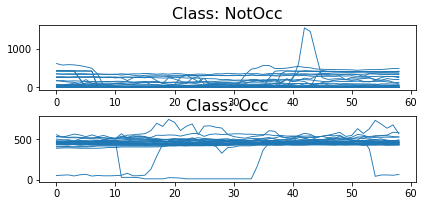

In [29]:
X=X_train
y=y_train

plt.figure()
for i, classe in enumerate(['NotOcc', 'Occ']):
    plt.subplot(3, 1, i + 1)
    for x in X[y == i]:
        #print(i)
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [30]:
X_train2 = shp_clf.transform(X_train)

135/135 [==============================] - 0s 859us/step


In [31]:
X_test2 = shp_clf.transform(X_test)

43/43 [==============================] - 0s 51us/step


In [32]:
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train2, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [33]:
y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

Accuracy 0.9767441860465116
F1-score [0.98245614 0.96551724]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       1.00      0.93      0.97        15

    accuracy                           0.98        43
   macro avg       0.98      0.97      0.97        43
weighted avg       0.98      0.98      0.98        43



array([[28,  0],
       [ 1, 14]])

In [34]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth= 4, 
                             min_samples_split=2, min_samples_leaf=1, random_state=0)
clf.fit(X_train2, y_train)

y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

Accuracy 0.9767441860465116
F1-score [0.98245614 0.96551724]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       1.00      0.93      0.97        15

    accuracy                           0.98        43
   macro avg       0.98      0.97      0.97        43
weighted avg       0.98      0.98      0.98        43



array([[28,  0],
       [ 1, 14]])

In [35]:
predicted_locations = shp_clf.locate(X_train)

135/135 [==============================] - 0s 834us/step


/opt/anaconda3/lib/python3.7/site-packages/tslearn/utils.py:63: UserWarning: 2-Dimensional data passed. Assuming these are 135 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


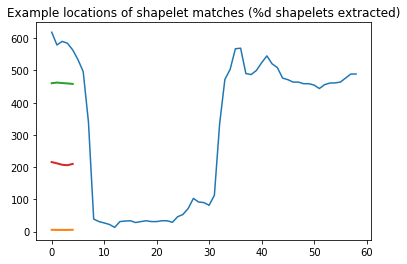

In [36]:
ts_id = 1
plt.figure()
n_shapelets = sum(shapelet_sizes.values())
plt.title("Example locations of shapelet matches "
          "(%d shapelets extracted)".format(n_shapelets))

plt.plot(X[19].ravel())
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)

In [37]:
import scipy.stats as stats

In [38]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        #'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [39]:
X_train3 = np.array([list(calculate_features(x).values()) for x in X_train])

In [40]:
X_train3.shape

(135, 12)

In [41]:
X_train3

array([[ 5.05847458e+01,  1.35145250e+02,  1.82642386e+04, ...,
         0.00000000e+00,  2.35864180e+00,  3.56319306e+00],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -3.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -3.00000000e+00],
       ...,
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -3.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -3.00000000e+00],
       [ 1.58282486e+02,  1.98168004e+02,  3.92705577e+04, ...,
         4.04000000e+02,  4.83505758e-01, -1.74481095e+00]])

In [42]:
X_test3 = np.array([list(calculate_features(x).values()) for x in X_test])

In [43]:
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_train3, y_train)

y_pred = clf.predict(X_test3)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 1.0
F1-score [1. 1.]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        15

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43



In [48]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D
from keras.layers import Conv1D, Activation, Conv1D, BatchNormalization

In [49]:
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train_cnn, y_train, test_size=0.2, stratify=y_train)

n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(y_train_cnn)), 1 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  59
N. LABELS:  2


In [50]:
def build_simple_cnn(n_timesteps, n_outputs):
    model = Sequential()
    
    model.add(Conv1D(filters=100, kernel_size=1, activation='relu', input_shape=(n_timesteps, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=150, kernel_size=1, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=200, kernel_size=1, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [51]:
cnn = build_simple_cnn(n_timesteps, n_outputs)

In [52]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [53]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train_cnn.shape[0]/10, batch_size))

In [54]:
history_cnn = cnn.fit(X_train_cnn, y_train_cnn, epochs=50, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn, y_val_cnn)).history

Train on 108 samples, validate on 27 samples
Epoch 1/50
108/108 [==============================] - 1s 12ms/step - loss: 0.6685 - accuracy: 0.8981 - val_loss: 0.8208 - val_accuracy: 0.7407
Epoch 2/50
108/108 [==============================] - 0s 2ms/step - loss: 0.6339 - accuracy: 0.8981 - val_loss: 1.0243 - val_accuracy: 0.8148
Epoch 3/50
108/108 [==============================] - 0s 2ms/step - loss: 0.5999 - accuracy: 0.9259 - val_loss: 0.8198 - val_accuracy: 0.8148
Epoch 4/50
108/108 [==============================] - 0s 3ms/step - loss: 0.5371 - accuracy: 0.9259 - val_loss: 0.6690 - val_accuracy: 0.8148
Epoch 5/50
108/108 [==============================] - 0s 2ms/step - loss: 0.3921 - accuracy: 0.9444 - val_loss: 0.5771 - val_accuracy: 0.8148
Epoch 6/50
108/108 [==============================] - 0s 2ms/step - loss: 0.2819 - accuracy: 0.9444 - val_loss: 0.6401 - val_accuracy: 0.8148
Epoch 7/50
108/108 [==============================] - 0s 2ms/step - loss: 0.1665 - accuracy: 0.9537 - 

In [55]:
y_pred = np.argmax(cnn.predict(X_test_cnn), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

Accuracy 0.9534883720930233
F1-score [0.96296296 0.9375    ]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        28
           1       0.88      1.00      0.94        15

    accuracy                           0.95        43
   macro avg       0.94      0.96      0.95        43
weighted avg       0.96      0.95      0.95        43



array([[26,  2],
       [ 0, 15]])